## Aligning PACE and EMIT Data
Adapted from "Projecting & GeoTIFF" tutorial on OB.DAAC's [Help Hub][help-hub] and from LP.DAAC's [VITALS][vitals] "Working with EMIT L2A Reflectance and ECOSTRESS L2 LSTE" tutorial.

Author: Skye Caplan (NASA, SSAI)
Last updated: 01/07/2026

<div class="alert alert-info" role="alert">

An [Earthdata Login][edl] account is required to access data from the NASA Earthdata system, including NASA PACE and EMIT data.

</div>

[edl]: https://urs.earthdata.nasa.gov/
[oci-data-access]: https://oceancolor.gsfc.nasa.gov/resources/docs/tutorials/notebooks/oci_data_access/
[emit-data-access]: https://nasa.github.io/VITALS/python/Exploring_EMIT_L2A_RFL.html
[help-hub]: https://nasa.github.io/oceandata-notebooks/
[vitals]: https://nasa.github.io/VITALS/

## Summary

This notebook will use the data downloaded from `01_Colocate_PACE_EMIT_data.ipynb` and the `rasterio` and `rioxarray` packages to put PACE and EMIT data on the same grid. We will use tools from LPDAAC's VITALS tutorials to orthorectify the EMIT data, and then place PACE and EMIT granules on a generalized grid using OCI's coarser resolution. We can then compare the data from the two sensors. These techniques will also be integral to our burn scar analysis in `03_NBR_with_PACE_EMIT.ipynb`.

## Learning Objectives

At the end of this notebook, you will know how to:
- Open and orthorectify an EMIT granule
- Take PACE L2 data from the instrument swath to a defined grid
- Downscale EMIT to PACE resolution
- Compare spectra between sensors

## Contents
1. [Setup](#1.-Setup)
2. [Gridding EMIT Data](#2.-Gridding-EMIT-Data)
3. [Projecting PACE Data onto a Defined Grid](#3.-Projecting-PACE-Data-onto-a-Defined-Grid)
4. [Regridding EMIT Data to Match PACE Resolution](#4.-Regridding-EMIT-Data-to-Match-PACE-Resolution)
5. [Comparing the Data](#5.-Comparing-the-Data)


## 1. Setup

Begin by importing all of the packages used in this notebook.

In [2]:
import xarray as xr 
import numpy as np 
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs 
import rioxarray as rio
import rasterio 
import cf_xarray 
import utils 
import cartopy
from rasterio.enums import Resampling
from rasterio.crs import CRS
from emit_tools import emit_xarray, spatial_subset, ortho_xr

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In the last notebook, we found and downloaded specific granules from before and after January #### 2025 to begin analyzing the LA wildfires. We'll be using those files for the rest of the tutorials in this series, and so define their paths for this notebook in the cell below.

In [3]:
# These are local paths from the first tutorial
# if necessary, grab this one too and mosaic for before: EMIT_L2A_RFL_001_20240825T173104_2423811_007
# NOTE: Find a good place to put these and pull them in? text file maybe
emit_paths = ["data/EMIT_L2A_RFL_001_20240825T173115_2423811_008.nc", # before
              "data/EMIT_L2A_RFL_001_20250324T220953_2508314_003.nc",
              "data/EMIT_L2A_MASK_001_20240825T173115_2423811_008.nc",
              "data/EMIT_L2A_MASK_001_20250324T220953_2508314_003.nc"] # after
oci_path = ["data/PACE_OCI.20241218T202231.L2.SFREFL.V3_1.nc",        # before
            "data/PACE_OCI.20250113T204049.L2.SFREFL.V3_1.nc"]        # after

Recall from the previous tutorial that these are Level-2 (L2) data. An important aspect of L2 data from any sensor is that that they are still in the instrument swath, meaning they are not on any predefined grid. Comparing the raw datasets, even doing so with two granules from the same sensor, would be inaccurate because the pixels do not represent the same location on the Earth. Especially because the eventual goal of this tutorial series is to compare data between sensors, we need to make sure our pixel centres have the same latitudes and longitudes - in other words, we have to grid our data.

To accomplish this gridding, we have to treat EMIT and PACE slightly differently. The EMIT L2A reflectance file comes with a geometry lookup table (GLT) in addition to the latitude and longitude of each pixel, which allows us to reproject the raw EMIT data onto a geographic grid. L2 Data from PACE does not have a GLT, so we will have to use another technique to project the data. 

The [VITALS][vitals] repository provides the `emit_tools` module which includes several functions to ease working with EMIT data. We'll use these first to orthorectify those data. More information can be found in the [EMIT-Data-Resources repository](https://github.com/nasa/EMIT-Data-Resources)

<div class="alert alert-warning" role="alert">

Should we orthorectify EMIT first and the reproject it again on the PACE grid? Probably, because will calc. nbr and then reproject up...

</div>

[vitals]: https://nasa.github.io/VITALS/

### 2. Gridding EMIT Data

The `emit_xarray` function in the `emit_tools` module is what will allow us to grid EMIT data. The `ortho=True` argument in the cell below tells the function to use the GLT to orthorectify the specific scene we feed it. Since we need both a "before" and "after" image to complete the burn analysis in the next tutorial(link when avail), we'll do this which each EMIT scene defined above.

We'll also mask out any fill values in the EMIT data by setting them to NaNs.

In [4]:
emit_pre = emit_xarray(emit_paths[0], ortho=True)
emit_post = emit_xarray(emit_paths[1], ortho=True)

emit_pre['reflectance'].data[emit_pre['reflectance'].data == -9999] = np.nan
emit_post['reflectance'].data[emit_post['reflectance'].data == -9999] = np.nan

EMIT data also comes with a quaity mask, which we will apply to the data. These also have to be orthorectified, and we can use the same function as above. Once we have the mask data, we can see which flags are provided in the mask. 

In [11]:
emit_pre_mask = emit_xarray(emit_paths[2], ortho=True)
emit_post_mask = emit_xarray(emit_paths[3], ortho=True)

emit_pre_mask['mask'].data[emit_pre_mask['mask'].data == -9999] = np.nan
emit_post_mask['mask'].data[emit_post_mask['mask'].data == -9999] = np.nan

emit_pre_mask.mask_bands.data.tolist()

['Cloud flag',
 'Cirrus flag',
 'Water flag',
 'Spacecraft Flag',
 'Dilated Cloud Flag',
 'AOD550',
 'H2O (g cm-2)',
 'Aggregate Flag']

In [17]:
# NOTE: Why different cases for "F/flag" in the mask?
emit_cld_mask = emit_pre_mask.sel(mask_bands=['Cloud flag', 'Cirrus flag', 'Spacecraft Flag'])
emit_cld_mask

<xarray.Dataset> Size: 706MB
Dimensions:      (latitude: 2020, longitude: 2184, mask_bands: 3,
                  packed_wavelength_bands: 36)
Coordinates:
  * latitude     (latitude) float64 16kB 34.39 34.39 34.39 ... 33.3 33.3 33.3
  * longitude    (longitude) float64 17kB -118.9 -118.9 -118.9 ... -117.8 -117.8
    elev         (latitude, longitude) float32 18MB nan nan nan ... nan nan nan
  * mask_bands   (mask_bands) object 24B 'Cloud flag' ... 'Spacecraft Flag'
    spatial_ref  int64 8B 0
Dimensions without coordinates: packed_wavelength_bands
Data variables:
    mask         (latitude, longitude, mask_bands) float32 53MB nan nan ... nan
    band_mask    (latitude, longitude, packed_wavelength_bands) float32 635MB ...
Attributes: (12/40)
    ncei_template_version:             NCEI_NetCDF_Swath_Template_v2.0
    summary:                           The Earth Surface Mineral Dust Source ...
    keywords:                          Imaging Spectroscopy, minerals, EMIT, ...
    Conventions:                       CF-1.63
    sensor:                            EMIT (Earth Surface Mineral Dust Sourc...
    instrument:                        EMIT
    ...                                ...
    spatial_ref:                       GEOGCS["WGS 84",DATUM["WGS_1984",SPHER...
    geotransform:                      [-1.18935184e+02  5.42232520e-04 -0.00...
    day_night_flag:                    Day
    title:                             EMIT L2A Masks 60 m V001
    granule_id:                        EMIT_L2A_MASK_001_20240825T173115_2423...
    Orthorectified:                    True

The `Aggregate Flag` is a aggregation of the first 5 data quality flags listed above, so we will use that to mask our reflectance data. 

In [6]:
#emit_pre_mask = emit_pre_mask.sel(mask_bands='Aggregate Flag')
#emit_post_mask = emit_post_mask.sel(mask_bands='Aggregate Flag')

emit_pre["reflectance"].data[emit_pre_mask["mask"].data == 1] = np.nan
emit_post["reflectance"].data[emit_post_mask["mask"].data == 1] = np.nan

Now we can plot these data to verify they're gridded and cloud masked. 

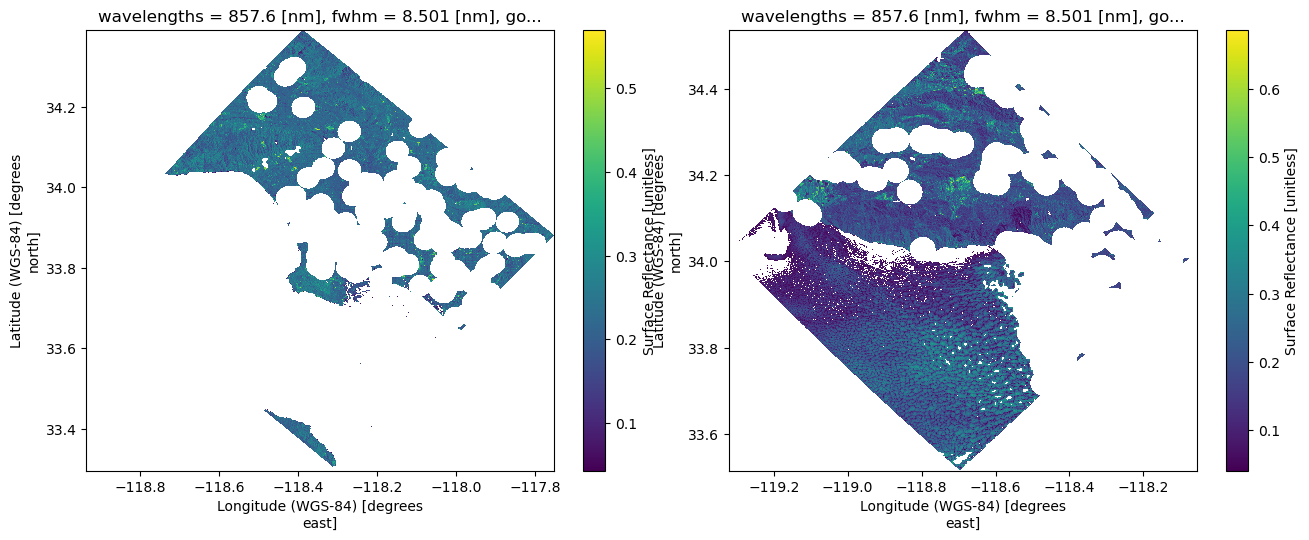

In [10]:
fig, ax = plt.subplots(1,2, figsize=(13,5))
fig.tight_layout()
emit_pre["reflectance"].sel(wavelengths=860, method="nearest").plot(ax=ax[0])
emit_post["reflectance"].sel(wavelengths=860, method="nearest").plot(ax=ax[1])
plt.show()

In [2]:
# Open files, have some text pointing to EMIT tools explainer and how 
# they are built to projet and orthorect. 
# Then walk through projecting the OCI data?
# Maybe explain the difference as well? 
# Mosaic the two emit granules using merge_emit from emit_tools?
# Should we try to use the un-orthorectified EMIT images instead? This works so far...

# NOTE: Likely change the name of the EMIT granules once we figure out what we're doing
emit = et.emit_xarray(emit_paths[0], ortho=True)
emit2 = et.emit_xarray(emit_paths[1], ortho=True)
# NOTE: Anywhere where "emit2" is ref'd below will be taken out once we mosaic the two

oci = utils.open_oci(oci_path)

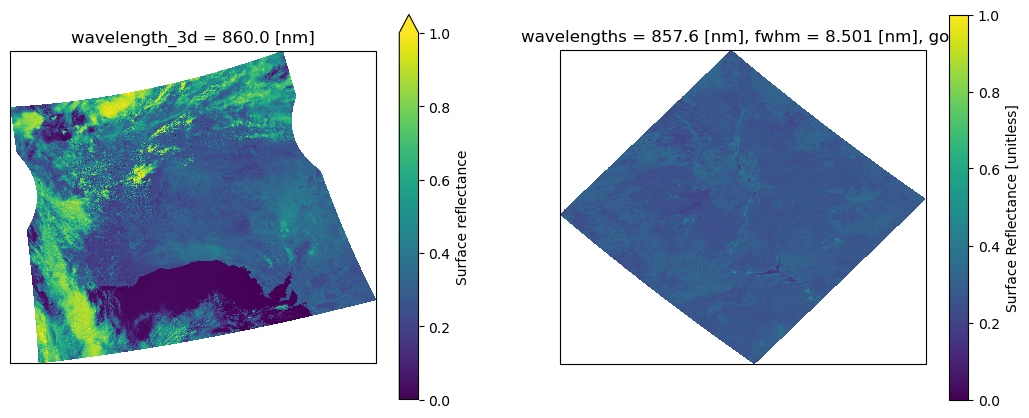

In [3]:
# Plot them on the same figure, point out how you can't even see the emit granules, 
# then zoom in and highlight 
fig, ax = plt.subplots(1,2, figsize=(13,5), 
                    subplot_kw=dict(projection=ccrs.PlateCarree()))
oci.rhos.sel({"wavelength_3d":860}, method="nearest").plot(x="longitude", y="latitude", vmin=0, vmax=1, ax=ax[0], transform=ccrs.PlateCarree())
emit.reflectance.sel({"wavelengths":860}, method="nearest").plot(vmin=0, vmax=1, ax=ax[1], transform=ccrs.PlateCarree())

#emit2.reflectance.sel({"wavelengths":860}, method="nearest").plot(vmin=0, vmax=1, ax=ax[1], transform=ccrs.PlateCarree())
plt.show()

## 2. Preparing PACE Data

Something like: Notice how in the cell above we had to be explicit about x and y in the plot function - it's not projected yet. Also, we can see a lot of clouds in the PACE granule, let's filter those out first before we tackle the projecting. If we print out the OCI dataset...

In [4]:
oci

<xarray.Dataset> Size: 1GB
Dimensions:        (number_of_lines: 1710, pixels_per_line: 1272,
                    wavelength_3d: 122)
Coordinates:
  * wavelength_3d  (wavelength_3d) float64 976B 346.0 351.0 ... 2.258e+03
    longitude      (number_of_lines, pixels_per_line) float32 9MB ...
    latitude       (number_of_lines, pixels_per_line) float32 9MB ...
Dimensions without coordinates: number_of_lines, pixels_per_line
Data variables:
    rhos           (number_of_lines, pixels_per_line, wavelength_3d) float32 1GB ...
    l2_flags       (number_of_lines, pixels_per_line) int32 9MB ...
Attributes: (12/47)
    title:                             OCI Level-2 Data SFREFL
    product_name:                      PACE_OCI.20250117T044314.L2.SFREFL.V3_...
    processing_version:                3.1
    history:                           l2gen par=/data12/sdpsoper/vdc/vpu11/w...
    instrument:                        OCI
    platform:                          PACE
    ...                                ...
    geospatial_lon_min:                112.491745
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     1.0332738161087036
    geospatial_bounds:                 POLYGON ((137.16154 -12.55706, 112.491...

...We'll see in addition to the ```rhos``` reflectance variable, there is also an ```l2_flags``` variable. ```l2_flags``` contains all of the quality information for each pixel in the OCI granule. If you click on the icon that looks like a page next to that vairable, you can see the shorthand for every condition flagged in PACE data. We can use these flag names, along with the ```cf_xarray``` package, to mask out certain quality issues or even features of the data. If you want more information on the meaning of each flag, please see [this website](https://oceancolor.gsfc.nasa.gov/resources/atbd/ocl2flags/). 

In the cell below, we have defined a masking function that takes in your dataset, the flag you're looking to mask, and a ```reverse``` argument. The defaults are set to flag clouds with "CLDICE" and ```reverse=False```, which will keep any pixel that is not marked as cloudy. ```reverse=True``` should only be used when you want to keep every pixel that is marked with that flag - for example, you might notice that "LAND" is a flag option, but there isn't one for water. In order to mask out the ocean, then, we could used ```mask_ds()``` with ```flag="LAND"``` and ```reverse=True``` to keep all pixels identified as land. 

CLDICE mask applied
LAND mask applied


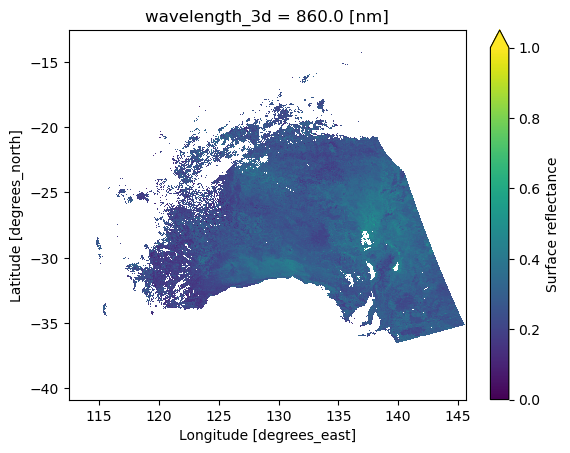

In [5]:
# TODO: Does LPDAAC prefer these types of functions in the utils file, 
#       or is this alright to stay in the notebook
def mask_ds(ds, flag="CLDICE", reverse=False):
    """
    Mask a PACE dataset for L2 flags. Default is to mask for clouds only
    Args:
        ds - xarray dataset containing "l2_flags" variable
        flag - str or list of l2 flag to mask for (see https://oceancolor.gsfc.nasa.gov/resources/atbd/ocl2flags/)
        reverse - boolean or list of booleans to keep only pixels with the desired flag. 
                  Default is False. E.g., set True to use "LAND" flag to mask water pixels. 
    Returns:
        Masked dataset
    """
    # Make sure flags are recognized by the package
    if ds["l2_flags"].cf.is_flag_variable:
        # If multiple flags, make sure reverse is also a list and then iterate
        if type(flag)==list:
            if type(reverse)!=list:
                reverse = [reverse for i in range(len(flag))]
            for f,r in zip(flag, reverse):
                if r == False:
                    ds = ds.where(~(ds["l2_flags"].cf == f))
                else:
                    ds = ds.where((ds["l2_flags"].cf == f))
                print(f"{f} mask applied")
            return ds
        else:
            if type(reverse)==list:
                reverse = reverse[0]
            print(type(flag))
            if reverse == False:
                ds = ds.where(~(ds["l2_flags"].cf == flag))
            else:
                ds = ds.where((ds["l2_flags"].cf == flag))
            print(f"{flag} mask applied")
            return ds
    else:
        print("l2_flags not recognized as flag variable")
        return ds

oci_masked = mask_ds(oci, flag=["CLDICE", "LAND"], reverse=[False,True])

# Quick plot to show it worked
oci_masked.rhos.sel({"wavelength_3d":860}, method="nearest").plot(x="longitude", 
                                                                  y="latitude", vmin=0, vmax=1)

Now that we've masked our data, we should project it. This is where we can get into our gridding function, first working on PACE OCI and then comparing OCI and EMIT, then scaling EMIT up to match PACE. So first, let's put PACE on a defined grid. 

(Text below adapted from oci_grid_match.ipynb on Help Hub)

## 3. Projecting PACE Data onto a Defined Grid

We can now move on to the actual gridding of our data. We'll do this by defining a grid with the optimal spatial resolution for the OCI dataset, which is 0.015 (~1.6 km at the equator) to account for the edge-of-swath pixel widening. Other than the resolution of our grid, we also need to know the bounds of our granule and the coordinate reference systems (CRSs) of the source and destination datasets to complete the gridding process. 

All of these things will go into building an affine transform, which is a sequence of six coefficients that tell the array how to restructure itself onto our desired grid. We'll define the `grid_data` function to take in our datasets and desired resolution, create the necessary grid, and project the data onto it. Because we'll eventually want to match grids with the EMIT granules we have above, we'll use EMIT's CRS as the ```dst_crs``` for OCI.

In [6]:
# TODO: We could try to make this more general to work with EMIT
def grid_data(src, resolution, dst_crs="epsg:4326", resampling=Resampling.nearest):
    """
    Reproject a L2 OCI dataset to match an input grid. Makes sure 3D variables are
        in (Z, Y, X) dimension order, and all variables have spatial dims/crs 
        assigned.
    Args:
        src - an xarray dataset or dataarray to reproject
        resolution - resolution of the output grid, in dst_crs units
        dst_crs - CRS of the output data
        resampling - resampling method (see rasterio.enums)
    Returns:
        dst - projected xr dataset
    """
    if (len(list(src.dims)) == 3) and (list(src.dims)[0] != "wavelength_3d"):
        src = src.transpose("wavelength_3d", ...)
    src = src.rio.set_spatial_dims("pixels_per_line", "number_of_lines")
    src = src.rio.write_crs("epsg:4326")

    # Calculating the default affine transform
    defaults = rasterio.warp.calculate_default_transform(
        src.rio.crs,
        dst_crs,
        src.rio.width,
        src.rio.height,
        left=src.attrs["geospatial_lon_min"],
        bottom=src.attrs["geospatial_lat_min"],
        right=src.attrs["geospatial_lon_max"],
        top=src.attrs["geospatial_lat_max"],
    )
    # Aligning that transform to our desired resolution
    transform, width, height = rasterio.warp.aligned_target(*defaults, resolution)
    
    dst = src.rio.reproject(
        dst_crs=dst_crs,
        shape=(height, width),
        transform=transform,
        src_geoloc_array=(
            src["longitude"],
            src["latitude"],
        ),
        nodata=np.nan,
        resample=resampling,
    )
    dst["x"] = dst["x"].round(9)
    dst["y"] = dst["y"].round(9)
    
    return dst.rename({"x":"longitude", "y":"latitude"})

resolution = (0.015, 0.015)

oci_gridded = grid_data(oci_masked, resolution, dst_crs=emit.rio.crs)

oci_gridded.rio.transform()

Affine(0.015, 0.0, 112.48500000000001,
       0.0, -0.015, -12.555)

The dataset should now be on a defined grid. We can take a look at its transform and see that it consists 6 numbers which represent:
- A[0] = x-component of the pixel size, in this case 0.015 degrees, which is ~1.6 km at the equator
- A[1] = rotation of the pixel around the x-axis (this is 0 for north-up images)
- A[2] = x coordinate (or longitude, here) of the upper left corner of the top left pixel (i.e., the westernmost pixel)
- A[3] = rotation of the pixel around the y-axis (this is 0 for north-up images)
- A[4] = y-component of the pixel size, in this case 0.015 degrees. Negative because rows in netCDF format (and GeoTIFF, and many others) increase downward, while a real-world y-axis would increase upward.
- A[5] = y coordinate (or latitude, here) of the upper left corner of the top left pixel (i.e., the northermost pixel)

Let's take a look at the EMIT transform and see the differences:

In [7]:
emit.rio.transform()

Affine(0.0005422325202563623, 0.0, 128.419904964916,
       0.0, -0.0005422325202563676, -28.1058619765659)

## 4. Regridding EMIT Data to Match PACE Resolution

Clearly, the resolution of the EMIT granules are much finer than that of the OCI granule, but we knew that going in! You can also see that the origins of the two granules are different, which makes sense because they cover different ground. However, the important parts of this are that the rotations are the same - both the OCI and EMIT datasets are north-up, so we don't have to do any more futzing in that area to get them aligned. Let's see what they look like on a plot together

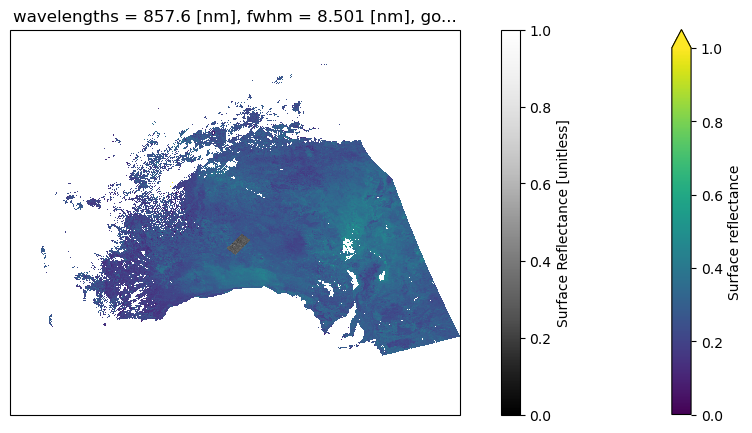

In [8]:
#TODO: Add bg cartopy elements, and maybe do this above to not be repetitive
fig, ax = plt.subplots(figsize=(13,5), subplot_kw=dict(projection=ccrs.PlateCarree()))
oci_gridded.rhos.sel({"wavelength_3d":860}, method="nearest").plot(vmin=0, vmax=1, transform=ccrs.PlateCarree())
emit.reflectance.sel({"wavelengths":860}, method="nearest").plot(vmin=0, vmax=1, cmap="Greys_r", transform=ccrs.PlateCarree())
emit2.reflectance.sel({"wavelengths":860}, method="nearest").plot(vmin=0, vmax=1, cmap="Greys_r", transform=ccrs.PlateCarree(), add_colorbar=False)
plt.show()

Zooming in on the overlapping area:

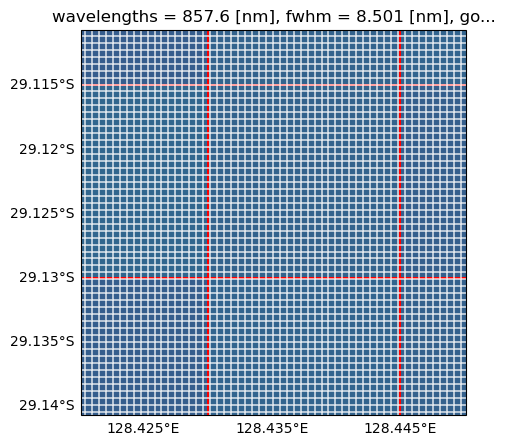

In [16]:
#TODO: Add bg cartopy elements, and maybe do this above to not be repetitive
fig, ax = plt.subplots(figsize=(13,5), subplot_kw=dict(projection=ccrs.PlateCarree()))
oci_gridded.rhos.sel({"wavelength_3d":860}, method="nearest").plot(vmin=0, vmax=1, transform=ccrs.PlateCarree(),linewidth=0.05, edgecolors="red", add_colorbar=False)
emit.reflectance.sel({"wavelengths":860}, method="nearest").plot(vmin=0, vmax=1, cmap="Greys_r", transform=ccrs.PlateCarree(),  linewidth=0.05, edgecolors="white", add_colorbar=False, alpha=0.4)
emit2.reflectance.sel({"wavelengths":860}, method="nearest").plot(vmin=0, vmax=1, cmap="Greys_r", transform=ccrs.PlateCarree(), linewidth=0.001, edgecolors="white", add_colorbar=False, alpha=0.4)
ax.set_extent([emit.longitude.min(), emit.longitude.min()+0.03, emit.latitude.min(), emit.latitude.min()+0.03])
ax.gridlines(draw_labels={"left": "y", "bottom": "x"}, alpha=0.0)
plt.show()

In [10]:
oci_gridded

<xarray.Dataset> Size: 2GB
Dimensions:        (longitude: 2208, latitude: 1888, wavelength_3d: 122)
Coordinates:
  * longitude      (longitude) float64 18kB 112.5 112.5 112.5 ... 145.6 145.6
  * latitude       (latitude) float64 15kB -12.56 -12.58 ... -40.85 -40.87
  * wavelength_3d  (wavelength_3d) float64 976B 346.0 351.0 ... 2.258e+03
    spatial_ref    int64 8B 0
Data variables:
    rhos           (wavelength_3d, latitude, longitude) float32 2GB nan ... nan
    l2_flags       (latitude, longitude) float64 33MB nan nan nan ... nan nan
Attributes: (12/47)
    title:                             OCI Level-2 Data SFREFL
    product_name:                      PACE_OCI.20250117T044314.L2.SFREFL.V3_...
    processing_version:                3.1
    history:                           l2gen par=/data12/sdpsoper/vdc/vpu11/w...
    instrument:                        OCI
    platform:                          PACE
    ...                                ...
    geospatial_lon_min:                112.491745
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     1.0332738161087036
    geospatial_bounds:                 POLYGON ((137.16154 -12.55706, 112.491...

There are a lot of EMIT pixels contained in one PACE pixel. If we wanted to make a 1:1 comparison, doing it with the raw EMIT data would be inaccurate since the locations of the PACE pixels don't match those of the EMIT pixels. (mention something about subpixel investigations, which is an idea for the next notebook in this series) In order to make a more fair comparison, we should downscale the EMIT data to match PACE's resolution. 

We can use the same packages as above to do this resampling 

In [13]:
# TODO: Make one fcn that works for both gridding pace and regridding emit?
def regrid_emit_data(src, resolution, dst_crs="epsg:4326", resampling=Resampling.nearest):
    """
    Reproject a L2 OCI dataset to match an input grid. Makes sure 3D variables are
        in (Z, Y, X) dimension order, and all variables have spatial dims/crs 
        assigned.
    Args:
        src - an xarray dataset or dataarray to reproject
        resolution - resolution of the output grid, in dst_crs units
        dst_crs - CRS of the output data
        resampling - resampling method (see rasterio.enums)
    Returns:
        dst - projected xr dataset
    """
    if (len(list(src.dims)) == 3) and (list(src.dims)[0] != "wavelengths"):
        src = src.transpose("wavelengths", ...)

    # Aligning that transform to our desired resolution
    transform, width, height = rasterio.warp.aligned_target(transform=src.rio.transform(), 
                                                            width=src.rio.width, 
                                                            height=src.rio.height,
                                                            resolution=resolution)
    
    dst = src.rio.reproject(
        dst_crs=dst_crs,
        shape=(height, width),
        transform=transform,
        nodata=np.nan,
        resample=resampling,
    )
    dst["x"] = dst["x"].round(9)
    dst["y"] = dst["y"].round(9)
    
    return dst.rename({"x":"longitude", "y":"latitude"})

emit_p015 = regrid_emit_data(emit, resolution=(0.015, 0.015), dst_crs=emit.rio.crs)
emit_p015

<xarray.Dataset> Size: 7MB
Dimensions:           (longitude: 82, latitude: 71, wavelengths: 285)
Coordinates:
  * longitude         (longitude) float64 656B 128.4 128.4 128.5 ... 129.6 129.6
  * latitude          (latitude) float64 568B -28.1 -28.12 ... -29.14 -29.15
    good_wavelengths  (wavelengths) float32 1kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    fwhm              (wavelengths) float32 1kB 8.415 8.415 ... 8.807 8.809
  * wavelengths       (wavelengths) float32 1kB 381.0 388.4 ... 2.493e+03
    spatial_ref       int64 8B 0
Data variables:
    reflectance       (wavelengths, latitude, longitude) float32 7MB nan ... nan
Attributes: (12/40)
    ncei_template_version:             NCEI_NetCDF_Swath_Template_v2.0
    summary:                           The Earth Surface Mineral Dust Source ...
    keywords:                          Imaging Spectroscopy, minerals, EMIT, ...
    Conventions:                       CF-1.63
    sensor:                            EMIT (Earth Surface Mineral Dust Sourc...
    instrument:                        EMIT
    ...                                ...
    spatial_ref:                       GEOGCS["WGS 84",DATUM["WGS_1984",SPHER...
    geotransform:                      [ 1.28419905e+02  5.42232520e-04 -0.00...
    day_night_flag:                    Day
    title:                             EMIT L2A Estimated Surface Reflectance...
    granule_id:                        EMIT_L2A_RFL_001_20250117T041449_25017...
    Orthorectified:                    True

In [14]:
emit_p015.rio.transform()

Affine(0.015, 0.0, 128.41500000000002,
       0.0, -0.015, -28.095)

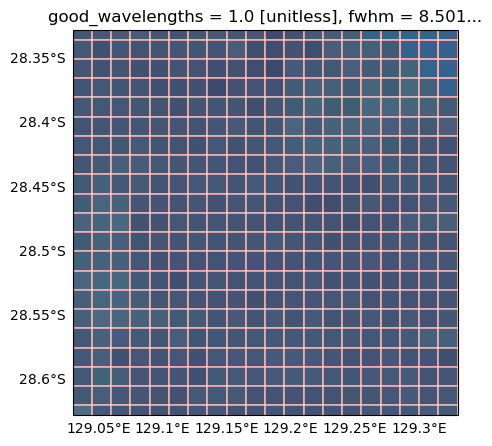

In [18]:
# Plot overlapping to show same size pixels
#TODO: Add bg cartopy elements, and maybe do this above to not be repetitive
fig, ax = plt.subplots(figsize=(13,5), subplot_kw=dict(projection=ccrs.PlateCarree()))
oci_gridded.rhos.sel({"wavelength_3d":860}, method="nearest").plot(vmin=0, vmax=1, transform=ccrs.PlateCarree(),linewidth=0.05, edgecolors="red", add_colorbar=False)
emit_p015.reflectance.sel({"wavelengths":860}, method="nearest").plot(vmin=0, vmax=1, cmap="Greys_r", transform=ccrs.PlateCarree(),  linewidth=0.05, edgecolors="white", add_colorbar=False, alpha=0.4)
#ax.set_extent([emit_p015.longitude.min(), emit_p015.longitude.min()+0.03, emit_p015.latitude.min(), emit_p015.latitude.min()+0.03])
ax.set_extent([emit_p015.longitude.median(), emit_p015.longitude.median()+0.3, emit_p015.latitude.median(), emit_p015.latitude.median()+0.3])
ax.gridlines(draw_labels={"left": "y", "bottom": "x"}, alpha=0.0)
plt.show()

## 5. Comparing the Data

Now we can compare some spectra from the same locations

In [19]:
# Subset:
oci_sub = oci_gridded.sel({"longitude": slice(emit_p015.longitude.median(), emit_p015.longitude.median()+0.3),
                         "latitude": slice(emit_p015.latitude.median()+0.3, emit_p015.latitude.median())})
emit_sub = emit_p015.sel({"longitude": slice(emit_p015.longitude.median(), emit_p015.longitude.median()+0.3),
                         "latitude": slice(emit_p015.latitude.median()+0.3, emit_p015.latitude.median())})
oci_sub

<xarray.Dataset> Size: 210kB
Dimensions:        (longitude: 20, latitude: 21, wavelength_3d: 122)
Coordinates:
  * longitude      (longitude) float64 160B 129.0 129.1 129.1 ... 129.3 129.3
  * latitude       (latitude) float64 168B -28.33 -28.34 ... -28.61 -28.63
  * wavelength_3d  (wavelength_3d) float64 976B 346.0 351.0 ... 2.258e+03
    spatial_ref    int64 8B 0
Data variables:
    rhos           (wavelength_3d, latitude, longitude) float32 205kB 0.04865...
    l2_flags       (latitude, longitude) float64 3kB 2.0 2.0 2.0 ... 2.0 2.0 2.0
Attributes: (12/47)
    title:                             OCI Level-2 Data SFREFL
    product_name:                      PACE_OCI.20250117T044314.L2.SFREFL.V3_...
    processing_version:                3.1
    history:                           l2gen par=/data12/sdpsoper/vdc/vpu11/w...
    instrument:                        OCI
    platform:                          PACE
    ...                                ...
    geospatial_lon_min:                112.491745
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     1.0332738161087036
    geospatial_bounds:                 POLYGON ((137.16154 -12.55706, 112.491...

In [33]:
pts = list(zip(oci_sub.latitude.data,oci_sub.longitude.data))
#list(pts)

In [21]:
oci_sub.rhos

<xarray.DataArray 'rhos' (wavelength_3d: 122, latitude: 21, longitude: 20)> Size: 205kB
array([[[0.04865091, 0.04877905, 0.0493311 , ..., 0.05122918,
         0.05165173, 0.0503725 ],
        [0.05003948, 0.0516249 , 0.05244735, ..., 0.05062668,
         0.05049799, 0.05001003],
        [0.04976271, 0.05035438, 0.05050731, ..., 0.04912104,
         0.0496656 , 0.04946366],
        ...,
        [0.06437763, 0.0807718 , 0.061214  , ..., 0.04995612,
         0.05107313, 0.05128691],
        [0.06341078, 0.05374236, 0.05259702, ..., 0.04910061,
         0.05056647, 0.05130302],
        [0.08665549, 0.05416431, 0.05299535, ..., 0.04893535,
         0.04970119, 0.05053781]],

       [[0.04638773, 0.04671878, 0.04703812, ..., 0.0484479 ,
         0.04789851, 0.04797393],
        [0.04576186, 0.04900395, 0.04952588, ..., 0.04860462,
         0.04789871, 0.04760817],
        [0.04721311, 0.04846039, 0.0474218 , ..., 0.04771964,
         0.04714177, 0.04795477],
...
        [0.31598365, 0.34291828, 0.3376544 , ..., 0.32546625,
         0.326409  , 0.3366856 ],
        [0.33845168, 0.34810343, 0.33568528, ..., 0.33703637,
         0.33022916, 0.34073293],
        [0.32581612, 0.35192218, 0.33295298, ..., 0.32861727,
         0.33242568, 0.36702308]],

       [[0.3632567 , 0.32318297, 0.334728  , ..., 0.38502067,
         0.38219324, 0.37221724],
        [0.33219725, 0.31852105, 0.32751432, ..., 0.37376076,
         0.3747448 , 0.3733591 ],
        [0.318386  , 0.31258184, 0.3224931 , ..., 0.38756996,
         0.3801111 , 0.37013942],
        ...,
        [0.30599818, 0.3365468 , 0.32588044, ..., 0.31301787,
         0.3142816 , 0.32438883],
        [0.32799813, 0.3345616 , 0.3219511 , ..., 0.31981182,
         0.3166217 , 0.3255118 ],
        [0.31831217, 0.33764812, 0.3191098 , ..., 0.3147764 ,
         0.31815737, 0.3457563 ]]], shape=(122, 21, 20), dtype=float32)
Coordinates:
  * longitude      (longitude) float64 160B 129.0 129.1 129.1 ... 129.3 129.3
  * latitude       (latitude) float64 168B -28.33 -28.34 ... -28.61 -28.63
  * wavelength_3d  (wavelength_3d) float64 976B 346.0 351.0 ... 2.258e+03
    spatial_ref    int64 8B 0
Attributes:
    long_name:   Surface reflectance
    valid_min:   -0.05
    valid_max:   1.5
    _FillValue:  nan

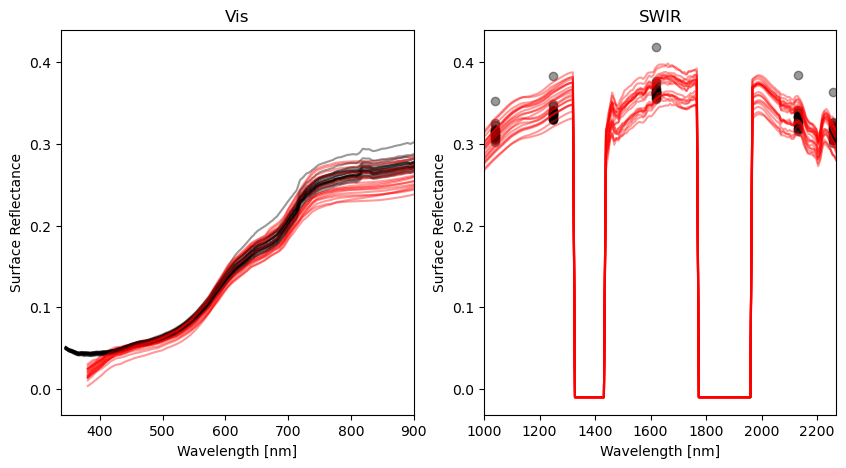

In [20]:
# TODO: Make a plot function for this
#       or make a better fun holoviews plot for it
pts = zip(oci_sub.latitude.data,oci_sub.longitude.data)

fig, ax = plt.subplots(1, 2, figsize=(10,5))

for pt in pts:
    ax[0].plot(oci_sub.wavelength_3d, oci_sub.rhos.sel({"latitude":pt[0], "longitude":pt[1]}), 
               alpha=0.4, c='k', label='OCI')
    ax[0].plot(emit_sub.wavelengths, emit_sub.reflectance.sel({"latitude":pt[0], "longitude":pt[1]}), 
               alpha=0.4, c='r', label='EMIT')
    ax[1].scatter(oci_sub.wavelength_3d, oci_sub.rhos.sel({"latitude":pt[0], "longitude":pt[1]}),
                   alpha=0.4, c='k', label='OCI')
    ax[1].plot(emit_sub.wavelengths, emit_sub.reflectance.sel({"latitude":pt[0], "longitude":pt[1]}),
                alpha=0.4, c='r', label='EMIT')
#ax[0].set_ylim([0.0, 1.1])
ax[0].set_xlim([339, 900])
ax[0].set_title("Vis")
ax[0].set_xlabel("Wavelength [nm]")
ax[0].set_ylabel("Surface Reflectance")

#ax[1].set_ylim([0.0, 0.1])
ax[1].set_xlim([1000, 2270])
ax[1].set_title("SWIR")
ax[1].set_xlabel("Wavelength [nm]")
ax[1].set_ylabel("Surface Reflectance")
plt.show()